In [1]:
# https://webpages.charlotte.edu/mirsad/itcs6265/group1/domain.html#:~:text=The%20Berka%20dataset%20is%20a,clients%20with%20approximately%201%2C000%2C000%20transactions.

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

#############################################################################################################################
################################################  READ FILES    #############################################################
#############################################################################################################################

# account
df_account = pd.read_csv(r"C:\Users\oliver.koehn\Documents\gitProjects\azureExamples_finance\eval_berka\in\account.asc", delimiter=";")
df_account["acc_dist_id"] = df_account["district_id"]
df_account['date'] = pd.to_datetime("19" + df_account['date'].astype(str), format='%Y-%m-%d')
df_account = df_account.rename(columns={'date': 'date_acc'})

# card
df_card = pd.read_csv(r"C:\Users\oliver.koehn\Documents\gitProjects\azureExamples_finance\eval_berka\in\card.asc", delimiter=";")
df_card['issued'] = pd.to_datetime("19" + df_card['issued'].astype(str), format='%Y-%m-%d')
df_card = df_card.rename(columns={'type': 'card_type'})

# client
df_client = pd.read_csv(r"C:\Users\oliver.koehn\Documents\gitProjects\azureExamples_finance\eval_berka\in\client.asc", delimiter=";")
df_client["cli_dist_id"] = df_client["district_id"]
df_client["MM"] = df_client['birth_number']//100 - df_client['birth_number']//10000*100
df_client['gender'] = 'M'
# it sa strang eformat where gende ris encoded like this
df_client.loc[df_client['MM']>50,'gender'] = 'F'
df_client.loc[df_client['gender']=='F','birth_number'] -= 5000
df_client['birth_number'] = pd.to_datetime("19" + df_client['birth_number'].astype(str), format='%Y-%m-%d')
df_client.rename(columns = {'birth_number':'date_birth'}, inplace=True)
df_client.drop('MM',1,inplace=True)

# disp
df_disp = pd.read_csv(r"C:\Users\oliver.koehn\Documents\gitProjects\azureExamples_finance\eval_berka\in\disp.asc", delimiter=";")
df_disp = df_disp.rename(columns={'type': 'disp_type'})

# district
df_district = pd.read_csv(r"C:\Users\oliver.koehn\Documents\gitProjects\azureExamples_finance\eval_berka\in\district.asc", delimiter=";")
df_district = df_district.rename(columns={'A1': 'district_id'})

# loan
df_loan = pd.read_csv(r"C:\Users\oliver.koehn\Documents\gitProjects\azureExamples_finance\eval_berka\in\loan.asc", delimiter=";")
df_loan['date'] = pd.to_datetime("19" + df_loan['date'].astype(str), format='%Y-%m-%d')
df_loan = df_loan.rename(columns={'date': 'date_loan'})

# order
df_order = pd.read_csv(r"C:\Users\oliver.koehn\Documents\gitProjects\azureExamples_finance\eval_berka\in\order.asc", delimiter=";")
df_order = df_order.rename(columns={'amount': 'order_amount'})
df_order['order_amount'] = df_order.order_amount.astype('float')
df_order_average = df_order.copy()
df_order_average = df_order_average.groupby('account_id').mean()
df_order_average = df_order_average.rename(columns={'order_amount': 'average_order_amount'})
df_order_average = df_order_average[["order_id", "average_order_amount"]]

# trans
df_trans = pd.read_csv(r"C:\Users\oliver.koehn\Documents\gitProjects\azureExamples_finance\eval_berka\in\trans.asc", delimiter=";")
df_trans['date'] = pd.to_datetime("19" + df_trans['date'].astype(str), format='%Y-%m-%d')
df_trans_average = df_trans.copy()
df_trans_average = df_trans_average.groupby('account_id').mean()
df_trans_average["account_id"] = df_trans_average.index
df_trans_average = df_trans_average.rename(columns={'amount': 'average_trans_amount', 'balance': 'average_trans_balance'})
df_trans_average = df_trans_average[['average_trans_amount', 'average_trans_balance']]
df_n_trans = df_trans.groupby('account_id').count()
df_n_trans = df_n_trans.rename(columns={'trans_id': 'n_trans'})
df_n_trans = df_n_trans[["n_trans"]]

#############################################################################################################################
################################################      JOIN      #############################################################
#############################################################################################################################


df = df_loan.merge(df_account, on = "account_id", how = "inner")\
    .merge(df_district, on = "district_id", how = "inner")\
    .merge(df_order_average, on = "account_id", how = "inner")\
    .merge(df_trans_average, on = "account_id", how = "inner")\
    .merge(df_disp, on = "account_id", how = "inner")\
    .merge(df_card, on = "disp_id", how = "left")\
    .merge(df_client, on = "client_id", how = "inner")\
    .merge(df_n_trans, on = "account_id", how = "inner")\

df = df[df["disp_type"] == "OWNER"]

# additional fields
df['days_between'] = (df['date_loan'] - df['date_acc']).dt.days
df['n_inhabitants'] = df.A4
df['average_salary'] = df.A11
df['average_unemployment_rate'] = df[['A12', 'A13']].mean(axis=1)
df['entrepreneur_rate'] = df['A14']
df['average_crime_rate'] = df[['A15', 'A16']].mean(axis=1) / df['n_inhabitants']
df['default'] = (df['status'] == 'B') | (df['status'] == 'D')

df['same_district'] = df['acc_dist_id'] == df['cli_dist_id']
df['date_opening_loan'] = pd.to_datetime(df['date_loan'], format='%Y-%m-%d')
df['owner_age_at_opening'] = (df['date_opening_loan']  - df['date_birth']).dt.days // 365

cat_cols = ["frequency", "card_type", "gender"]
num_cols = ['amount', 'duration', 'payments', 'days_between', 'n_inhabitants', 
            'average_salary', 'average_unemployment_rate', 'entrepreneur_rate', 
            'average_crime_rate', 'average_order_amount', 'average_trans_amount',
            'average_trans_balance', 'n_trans', 'owner_age_at_opening', 
            'same_district']
list_features = num_cols + cat_cols

df[list_features]

C:\Users\oliver.koehn\AppData\Local\Temp\ipykernel_24028\401166657.py:33: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_client.drop('MM',1,inplace=True)
C:\Users\oliver.koehn\AppData\Local\Temp\ipykernel_24028\401166657.py:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_order_average = df_order_average.groupby('account_id').mean()
C:\Users\oliver.koehn\AppData\Local\Temp\ipykernel_24028\401166657.py:58: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_trans = pd.read_csv(r"C:\Users\oliver.koehn\Documents\gitProjects\azureExamples_finance\eval_berka\in\trans.asc", delimiter=";")
C:\Users\oliver.koehn\AppData\Local\Temp\ipykernel_24028\401166657.py:

,amount,duration,payments,days_between,n_inhabitants,average_salary,average_unemployment_rate,entrepreneur_rate,average_crime_rate,average_order_amount,average_trans_amount,average_trans_balance,n_trans,owner_age_at_opening,same_district,frequency,card_type,gender
0,96396,12,8033.0,105,94812,9650,3.67,100,0.029574,8033.2,10195.761538,44264.536725,403,45,True,POPLATEK TYDNE,NaN,F
1,52128,24,2172.0,264,94812,9650,3.67,100,0.029574,2172.0,6031.299430,45315.962357,526,34,False,POPLATEK MESICNE,classic,F
2,165960,36,4610.0,148,112709,8369,2.31,117,0.023228,3288.0,7506.822275,43499.768562,633,24,True,POPLATEK MESICNE,NaN,M
3,390096,48,8127.0,163,112709,8369,2.31,117,0.023228,8762.0,8492.995322,47488.105263,171,18,True,POPLATEK MESICNE,junior,M
5,219456,48,4572.0,108,112709,8369,2.31,117,0.023228,4572.0,12183.742857,63611.167857,84,37,True,POPLATEK MESICNE,NaN,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
821,311232,48,6484.0,542,127369,8369,5.88,107,0.022038,6483.7,15935.443726,73529.315970,263,51,True,POPLATEK MESICNE,classic,F
822,196224,48,4088.0,168,127369,8369,5.88,107,0.022038,7222.0,17135.291489,75639.472340,94,47,True,POPLATEK MESICNE,gold,M
823,31140,60,519.0,326,127369,8369,5.88,107,0.022038,519.0,2243.921687,35676.313253,83,21,True,POPLATEK MESICNE,NaN,M
824,88200,36,2450.0,462,127369,8369,5.88,107,0.022038,3067.1,5373.193103,41158.959483,116,53,True,POPLATEK MESICNE,NaN,M


682

C:\Users\oliver.koehn\AppData\Local\Temp\ipykernel_24028\3315507095.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df[list_features + ["default"]].corr(),


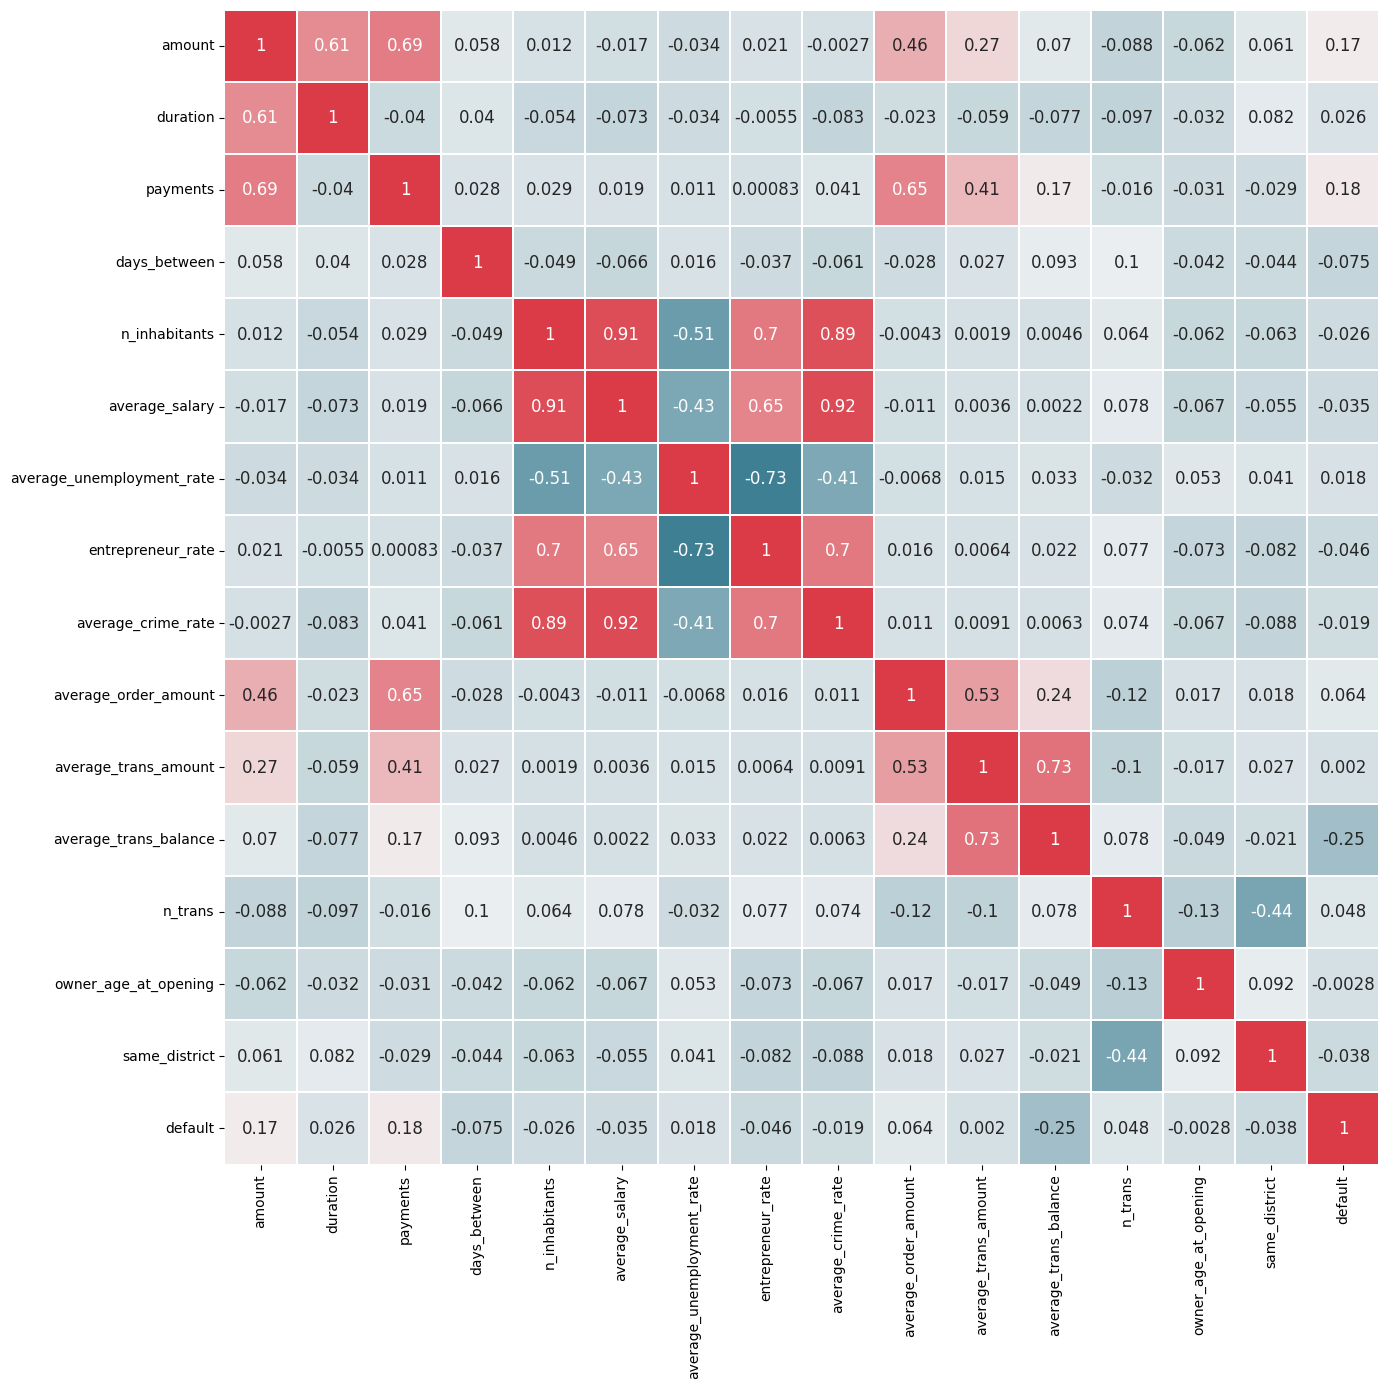

In [3]:
fig, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(
        df[list_features + ["default"]].corr(), 
        cmap = sns.diverging_palette(220, 10, as_cmap = True),
        square=True, 
        cbar=False,
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 })
plt.show()

In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from imblearn.over_sampling import RandomOverSampler

# https://scikit-learn.org/1.0/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html#sklearn.metrics.ConfusionMatrixDisplay.from_predictions

col_trans = ColumnTransformer([
    ('num', MinMaxScaler(), num_cols),
    ('cat', OneHotEncoder(drop='if_binary'), cat_cols)
])

df_transformed = col_trans.fit_transform(df[list_features])
X = df_transformed[:, :]
y = df["default"].map({False: 0, True: 1})

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=10)

# oversampling is important, check difference!!
# Apply oversampling to the training set
oversampler = RandomOverSampler(random_state=42)
X_train, y_train = oversampler.fit_resample(X_train, y_train)


# See the inital model performance
clf = RandomForestClassifier(random_state=10)
print('Acc:', cross_val_score(clf, X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring='accuracy').mean())
print('F1:', cross_val_score(clf, X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring='f1').mean())
print('ROC AUC:', cross_val_score(clf, X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring='roc_auc').mean())

params = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

Acc: 0.9929342151061608
F1: 0.9929958146133646
ROC AUC: 1.0


In [4]:
# Takes long
if 1 == 2:
    clf = GridSearchCV(RandomForestClassifier(random_state=10), param_grid=params, 
                    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=10), scoring='f1')
    clf.fit(X_train, y_train)

    print(clf.best_params_) # {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 10}
    print(clf.best_score_)

In [5]:
# train network
clf = RandomForestClassifier(n_estimators=10,
                             max_depth=10,
                             min_samples_split=5,
                             min_samples_leaf=2,
                             random_state=11)
clf.fit(X_train, y_train)


RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=10, random_state=11)

In [6]:
# get the feature importance
feat_names_num = list(col_trans.transformers_[0][1].get_feature_names_out())
feat_names_cat = list(col_trans.transformers_[1][1].get_feature_names_out())
feature_names = feat_names_num + feat_names_cat
df_importance = pd.DataFrame({'feature': feature_names, 'importance': clf.feature_importances_})
df_importance.sort_values('importance', ascending=False)

,feature,importance
0,amount,0.135787
11,average_trans_balance,0.116298
9,average_order_amount,0.096690
10,average_trans_amount,0.096137
2,payments,0.086095
3,days_between,0.064518
12,n_trans,0.062915
13,owner_age_at_opening,0.049776
6,average_unemployment_rate,0.046123
7,entrepreneur_rate,0.040503


In [7]:
# save
try:
    df = df.reset_index()
except:
    pass
from sklearn.pipeline import Pipeline
pipeline = Pipeline([('transformer', col_trans),('classifier', clf)])
j_berka = {}
j_berka["network"] = pipeline
j_berka["df"] = df
j_berka["num_cols"] = num_cols
j_berka["cat_cols"] = cat_cols

with open('berka.pickle', 'wb') as f:
    pickle.dump(j_berka, f)


In [8]:
# yields same result as below

j = []
for i in range(len(df)):
    j_dummy = {}
    j_dummy["true"] = 1 if df["default"][i] else 0
    x = df[num_cols + cat_cols].iloc[i].to_frame().T
    j_dummy["pred"] = pipeline.predict(x)[0]
    j.append(j_dummy)
    
df_pred = pd.DataFrame(j)
tp = 0
tn = 0
fp = 0
fn = 0
for i, r in df_pred.iterrows():
    if (r["true"] == 1) and (r["pred"] == 1):
        tp = tp + 1
    elif (r["true"] == 1) and (r["pred"] == 0):
        fn = fn + 1
    elif (r["true"] == 0) and (r["pred"] == 1):
        fp = fp + 1
    elif (r["true"] == 0) and (r["pred"] == 0):
        tn = tn + 1

print("tp: " + str(tp))
print("tn: " + str(tn))
print("fp: " + str(fp))
print("fn: " + str(fn))

tp: 57
tn: 588
fp: 18
fn: 19


Train Acc: 0.9941037735849056
Train F1: 0.9941383352872216
Train ROC AUC: 0.9999499377002492
test Acc: 0.8439024390243902
test F1: 0.19999999999999998
test ROC AUC: 0.6740324892498806


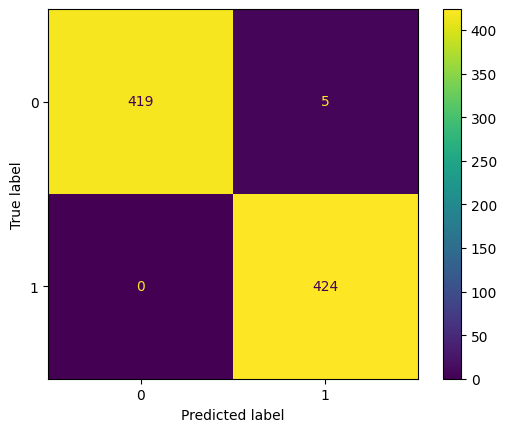

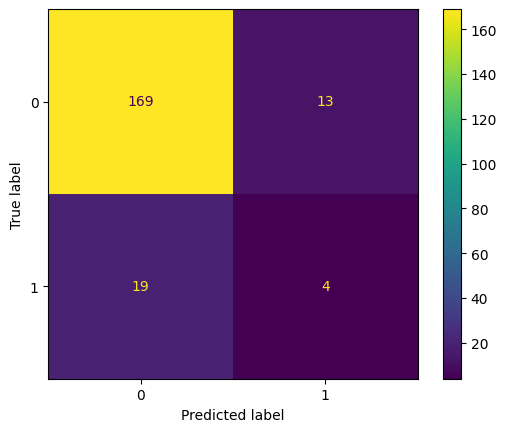

In [9]:
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = clf.predict(X_train)
y_train_proba = clf.predict_proba(X_train)
y_test_pred = clf.predict(X_test)
y_test_proba = clf.predict_proba(X_test)

print('Train Acc:', accuracy_score(y_train, y_train_pred))
print('Train F1:', f1_score(y_train, y_train_pred))
print('Train ROC AUC:', roc_auc_score(y_train, y_train_proba[:, 1]))

ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)

print('test Acc:', accuracy_score(y_test, y_test_pred))
print('test F1:', f1_score(y_test, y_test_pred))
print('test ROC AUC:', roc_auc_score(y_test, y_test_proba[:, 1]))
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)


In [10]:
import pickle
import pandas as pd

with open('berka.pickle', 'rb') as f:
    berka = pickle.load(f)

df = berka["df"]
pipeline = berka["network"]
num_cols = berka["num_cols"]
cat_cols = berka["cat_cols"]

# yields same result as below

j = []
for i in range(len(df)):
    j_dummy = {}
    j_dummy["true"] = 1 if df["default"][i] else 0
    x = df[num_cols + cat_cols].iloc[i].to_frame().T
    j_dummy["pred"] = pipeline.predict(x)[0]
    j.append(j_dummy)
    
df_pred = pd.DataFrame(j)
tp = 0
tn = 0
fp = 0
fn = 0
for i, r in df_pred.iterrows():
    if (r["true"] == 1) and (r["pred"] == 1):
        tp = tp + 1
    elif (r["true"] == 1) and (r["pred"] == 0):
        fn = fn + 1
    elif (r["true"] == 0) and (r["pred"] == 1):
        fp = fp + 1
    elif (r["true"] == 0) and (r["pred"] == 0):
        tn = tn + 1

print("tp: " + str(tp))
print("tn: " + str(tn))
print("fp: " + str(fp))
print("fn: " + str(fn))

tp: 57
tn: 588
fp: 18
fn: 19


In [11]:
df_loan

,loan_id,account_id,date_loan,amount,duration,payments,status
0,5314,1787,1993-07-05,96396,12,8033.0,B
1,5316,1801,1993-07-11,165960,36,4610.0,A
2,6863,9188,1993-07-28,127080,60,2118.0,A
3,5325,1843,1993-08-03,105804,36,2939.0,A
4,7240,11013,1993-09-06,274740,60,4579.0,A
...,...,...,...,...,...,...,...
677,4989,105,1998-12-05,352704,48,7348.0,C
678,5221,1284,1998-12-05,52512,12,4376.0,C
679,6402,6922,1998-12-06,139488,24,5812.0,C
680,5346,1928,1998-12-06,55632,24,2318.0,C
